In [1]:
import numpy as np
import time
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm

import random
from math import log, pi

In [2]:
# Use Aer's qasm_simulator
backend = Aer.get_backend('qasm_simulator')

In [3]:
# Define layer of quantum circuit.
# For now let's just parameterize the single qubit gates

def rotations(circ, q, n, params):
    for i in range(n):
        angles = params[i,:]
        circ.u3(angles[0], angles[1], 0, q[i])

def FC(circ, q, n):
    for i in range(n):
        for j in range(n):
            if i != j:
                circ.cx(q[i], q[j])
                
def layer(circ, q, n, params):
    rotations(circ, q, n, params)
    FC(circ, q, n)
    return circ

In [4]:
# function for creating a target distribution
def get_target():
    d ={
    '000': 1/2,
    '001': 0,
    '010': 0,
    '011': 0,
    '100': 0,
    '101': 0,
    '110': 0,
    '111': 1/2
    }
    return d

# define the cost function, here being the KL divergence between the target and learned distributions
def get_cost(target, learned, shots):
    epsilon = 0.01
    cost = 0
    for key in target:
        if key not in learned:      
            learned[key] = 0         # adds any keys to learned for which we got no counts 
        learned[key] /= shots        # normalize counts from measurements
        
        if target[key] != 0:
            cost += target[key]*(log(target[key]) - log(max(epsilon, learned[key])))
    
    return cost

def costFunc(params, shots=1000):
    n = 3
    params = np.reshape(params, (n,2))
    learned = run_circuit(n, params, shots)
    target = get_target()
    cost = get_cost(target, learned, shots)
    
    return cost

def run_circuit(n, params, shots):
    q = QuantumRegister(n)                  #can these be initialized outside the function?
    c = ClassicalRegister(n)
    circ = QuantumCircuit(q, c)
    
    output = layer(circ, q, n, params)
    for i in range(n):
        output.measure(q[i], c[i])
    result = execute(output, backend = backend, shots = shots)
    learned = result.result().get_counts(output)
    
    return learned

In [5]:
# Particle swarm optimizer

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant
        
        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()
            
            # We need to account for the fact that parameters are angles
            dist_cog = self.pos_best_i[i]-self.position_i[i]
            if dist_cog > pi:
                dist_cog -= 2*pi
            if dist_cog < -pi:
                dist_cog += 2*pi
                
            dist_soc = pos_best_g[i] - self.position_i[i]
            if dist_soc > pi:
                dist_soc -= 2*pi
            if dist_soc < -pi:
                dist_soc += 2*pi

            vel_cognitive=c1*r1*dist_cog
            vel_social=c2*r2*dist_soc
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            #account for particles crossing the 0=2pi line
            if self.position_i[i] > 2*pi:
                self.position_i[i] -= 2*pi
            
            if self.position_i[i] < 0:
                self.position_i[i] += 2*pi
            
            # adjust maximum position if necessary
          #  if self.position_i[i]>bounds[1]:
          #      self.position_i[i]=bounds[1]

            # adjust minimum position if neseccary
          #  if self.position_i[i] < bounds[0]:
          #      self.position_i[i]=bounds[0]
                
    
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print('FINAL:')
        print(pos_best_g)
        print(err_best_g)

if __name__ == "__PSO__":
    main()

1.8156827739566646


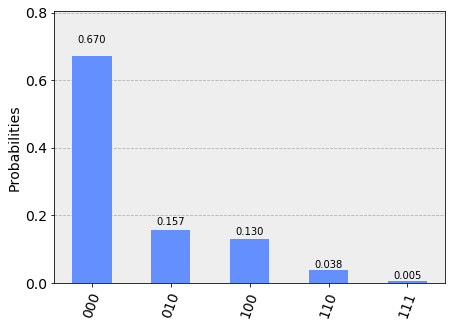

In [6]:
#Test getting cost function from initial parameters

n = 3
q = QuantumRegister(n)
c = ClassicalRegister(n)
circ = QuantumCircuit(q,c)

shots = 1000

# initial gate parameters
#params = np.random.normal(size=[n, 2])
params = np.array([[0.89616875, 1.21379434], [0.89128765, 1.25003966], [ 0.13975626, -0.14320516]])

learned = run_circuit(n, params, shots)

print(costFunc(params))
plot_histogram(learned)

In [7]:
# Run optimization
initial = np.random.normal(size=[n, 2])
bounds = [0, 2*pi]
PSO(costFunc, initial.flatten(), bounds, num_particles=20, maxiter=50)

FINAL:
[0.02205993181940339, 1.7916182235597133, 0.04586320566975832, 4.64204955093646, 4.719931047993748, 1.7275822683604352]
0.0


0.0023053062788416234


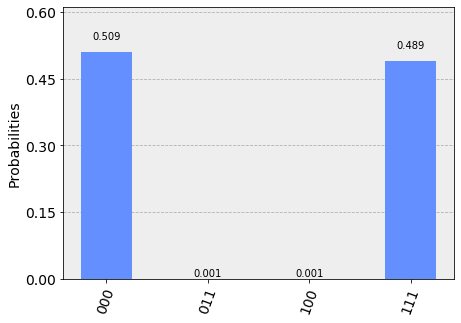

In [8]:
n = 3
q = QuantumRegister(n)
c = ClassicalRegister(n)
circ = QuantumCircuit(q,c)

shots = 1000

# initial gate parameters
#params = np.random.normal(size=[n, 2])
params = np.reshape([0.02205993181940339, 1.7916182235597133, 0.04586320566975832, 4.64204955093646, 4.719931047993748, 1.7275822683604352], (n,2))

print(costFunc(params))

output = layer(circ, q, n, params)

for i in range(n):
    output.measure(q[i], c[i])
    
result = execute(output, backend=backend, shots=shots)
learned = result.result().get_counts(output)      #outputs in a dict with keys '000', '001' etc
plot_histogram(result.result().get_counts(output))

In [15]:
params = [[-1.41149411, -0.63400851,  0.14374378], [-0.67474257, -1.08834468, -0.268572], [-2.4595944 , -0.90954018,  0.68306977]]
print(params)
print(params[0])

[[-1.41149411, -0.63400851, 0.14374378], [-0.67474257, -1.08834468, -0.268572], [-2.4595944, -0.90954018, 0.68306977]]
[-1.41149411, -0.63400851, 0.14374378]


In [22]:
params2 = np.random.normal(size=[n, 2])
print(params2)
print(params2[0,:])

[[-0.37711583 -1.30572404 -0.36828176]
 [-1.16104043  0.95587773 -0.61019794]
 [-0.67758437 -1.04086556  1.21629317]]
[-0.37711583 -1.30572404 -0.36828176]


In [100]:
np.random.normal(size=[n, 2]).flatten()

array([-0.49254391, -0.14550551,  0.65136616,  0.87832366, -0.75502212,
        1.481088  ])

In [21]:
params3 = np.array(params)
params3[0,:]

array([-1.41149411, -0.63400851,  0.14374378])

In [89]:
abs(-1)

1

In [80]:
'000' not in a.keys()

False

In [81]:
a['extra']=-1

In [90]:
max(1,2)

2

In [96]:
pi

3.141592653589793

In [101]:
a=[1,2,3,4,5,6]
a

[1, 2, 3, 4, 5, 6]

In [105]:
a = np.reshape(a, (2,3))
a

array([[1, 2, 3],
       [4, 5, 6]])

In [115]:
a = target()
a

{'000': 0.5,
 '001': 0,
 '010': 0,
 '011': 0,
 '100': 0,
 '101': 0,
 '110': 0,
 '111': 0.5}